### Manipulation of Peaks de novo results of Prochlorococus MED4 LC-MS/MS data using python.

Starting with:

    Peaks de novo results (.csv) of PTM-optimized sequencing

Goal:

    Files with stripped (no PTMs) peptide lists and
    Columns with #'s of each modification in every sequence
    Column with stripped peptide lengths (# amino acids)
    
### To use:

#### 1. Change the input file name in *IN 4*
#### 2. Change output file name in *IN 6*, *IN 7*, *IN 8*

For technical duplicates, I exported PeaksDN search results CSVs into my ETNP 2017 git repo:

In [1]:
cd /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/

/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN


In [34]:
ls

 interpro/
 med2_1_1fdr_db_nomods.jpg
 med2_1_1fdr_db_nomods.svg
 med2_1_Comet.2.5.png
 med2_1_dn_50alc_nomods.png
 med2_1_dn_80alc_nomods.png
 med2_1_dno_50alc_nomods.png
 med2_1_PeaksDN50.png
 med2_1_PeaksDN80.png
 med2_1_PepProp.90.png
 med2_2_Comet.2.5.png
 med2_2_DN50.png
 med2_2_DN80.png
 med2_2_PepProp.90.png
 MED2_combine_CometXCorr2.5_lca.csv
 MED2_combine_CometXCorr2.5_lca.ods
 MED2_combine_CometXCorr3_lca.csv
 MED2_combine_CometXCorr3_lca.ods
 MED2_combine_CometXCorr3_length_spec.csv
 MED2_combine_CometXCorr3_length_spec.ods
'med2_combined_Comet>2.5_treeview_to_Pro.png'
 med2_combined_DN50_treeview_to_Pro.png
 med2_combined_dn80.png
 med2_combined_DN80_treeview_to_Pro.png
 MED2_combine_DN50_lca.csv
 MED2_combine_DN50_lca.ods
 MED2_combine_DN50_length_spec.csv
 MED2_combine_DN50_length_spec.ods
 MED2_combine_DN80_lca.csv
 MED2_combine_DN80_lca.ods
 MED2_combine_DN80_length_spec.csv
 MED2_combine_DN80_length_spec.ods
 med2_combined_PepProp90.png
 MED4_GRaa_tryptic_peptides_LCA

In [3]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

'1.0.5'

In [4]:
#read the CSVs for each replicate into a datadrame we name 'comet' using the pandas read_csv function
peaks50_1 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_1_PTMopt_DN50.csv")
peaks50_2 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_2_PTMopt_DN50.csv")

frames = [peaks50_1, peaks50_2]

# concatenate dataframes
peaks50 = pd.concat(frames, sort=False)

# look at the dataframe
peaks50.head()

# also make a dataframe but keep only peptides  >80% ALC
peaks80 = peaks50.loc[peaks50['ALC (%)'] >= 80].copy()

# how many de novo sequence candidates >50% ALC?
print("# redundant Peaks peptides >50% ALC in combined dataframe", len(peaks50))
# how many de novo sequence candidates >80ALC?
print("# redundant Peaks peptides >80% ALC in combined dataframe", len(peaks80))

# redundant Peaks peptides >50% ALC in combined dataframe 33188
# redundant Peaks peptides >80% ALC in combined dataframe 13522


The peptide column has the masses of modifications (e.g., 57.02 Da for carbamidomethylation of cysteine). We want to make new columns with all that information and make a column with only the 'stripped' peptide sequence that's just amino acids - this we can then align against other sequences, for example.

Modified residues were allowed for:

    fixed carbamodimethylation of cysteine 57.021464 C
    varialbe oxidation of methionine: 15.9949 M
    variable deamidation of asparagine, glumatine: 0.984016 NQ
    variable iron cation on lysine: 53.919289 K
    variable methylation of lysine and arginine: 14.015650 KR

We'll then write this manipulated dataframe to a new file.

In [5]:
# use a count function to enumerate the # of A's (alanines) in each peptide
peaks50['A'] = peaks50['Peptide'].str.count("A")

# use a count function to enumerate the # of C's (cysteines) in each peptide
peaks50['C'] = peaks50['Peptide'].str.count("C")

# use a count function to enumerate the # of D's (aspartic acids) in each peptide
peaks50['D'] = peaks50['Peptide'].str.count("D")

# use a count function to enumerate the # of E's (glutamic acids) in each peptide
peaks50['E'] = peaks50['Peptide'].str.count("E")

# use a count function to enumerate the # of F's (phenylalanines) in each peptide
peaks50['F'] = peaks50['Peptide'].str.count("F")

# use a count function to enumerate the # of G's (glycines) in each peptide
peaks50['G'] = peaks50['Peptide'].str.count("G")

# use a count function to enumerate the # of H's (histidines) in each peptide
peaks50['H'] = peaks50['Peptide'].str.count("H")

# use a count function to enumerate the # of I's (isoleucines) in each peptide
# in peaks50 output, there will be no isoleucines (they're lumped in with leucines)
peaks50['I'] = peaks50['Peptide'].str.count("I")

# use a count function to enumerate the # of K's (lysines) in each peptide
peaks50['K'] = peaks50['Peptide'].str.count("K")

# use a count function to enumerate the # of L's (leucines) in each peptide
# also these include the isoleucines
peaks50['I/L'] = peaks50['Peptide'].str.count("L")

# use a count function to enumerate the # of M's (methionines) in each peptide
peaks50['M'] = peaks50['Peptide'].str.count("M")

# use a count function to enumerate the # of N's (asparagines) in each peptide
peaks50['N'] = peaks50['Peptide'].str.count("N")

# use a count function to enumerate the # of P's ([prolines]) in each peptide
peaks50['P'] = peaks50['Peptide'].str.count("P")

# use a count function to enumerate the # of Q's (glutamines) in each peptide
peaks50['Q'] = peaks50['Peptide'].str.count("Q")

# use a count function to enumerate the # of R's (arginines) in each peptide
peaks50['R'] = peaks50['Peptide'].str.count("R")

# use a count function to enumerate the # of S's (serines) in each peptide
peaks50['S'] = peaks50['Peptide'].str.count("S")

# use a count function to enumerate the # of T's (threonines) in each peptide
peaks50['T'] = peaks50['Peptide'].str.count("T")

# use a count function to enumerate the # of V's (valines) in each peptide
peaks50['V'] = peaks50['Peptide'].str.count("V")

# use a count function to enumerate the # of W's (tryptophans) in each peptide
peaks50['W'] = peaks50['Peptide'].str.count("W")

# use a count function to enumerate the # of Y's (tyrosines) in each peptide
peaks50['Y'] = peaks50['Peptide'].str.count("Y")

# use a count function to enumerate the # of carbamidomethylated C's in each peptide
peaks50['c-carb'] = peaks50['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks50['m-oxid'] = peaks50['Peptide'].apply(lambda x: x.count('M(+15.99)'))

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks50['n-deam'] = peaks50['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks50['n-deam'] = peaks50['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks50['q-deam'] = peaks50['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of iron adducted K's in each peptide
peaks50['k-iron'] = peaks50['Peptide'].str.count("53.92")

# use a count function to enumerate the # of methylated K's in each peptide
peaks50['k-meth'] = peaks50['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks50['r-meth'] = peaks50['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks50['stripped peptide'] = peaks50['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks50['stripped length'] = peaks50['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks50['ptm-total'] = peaks50['c-carb'] + peaks50['m-oxid'] + peaks50['n-deam'] + peaks50['q-deam'] + peaks50['k-iron'] + peaks50['k-meth'] + peaks50['r-meth']

# calculate NAAF numerator for each peptide k
peaks50['NAAF num.'] = peaks50['Area'] / peaks50['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks50.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50.csv")


# check out the results
peaks50.head(10)

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,m-oxid,n-deam,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length,ptm-total,NAAF num.
0,3,15768,022016_RAL4_95_MED2_trypsin_1.raw,KELN(+.98)LDTDLGK,11,98,11,623.8295,2,26.80,...,0,1,0,0,0,0,KELNLDTDLGK,11,1,2.381818e+05
1,3,6171,022016_RAL4_95_MED2_trypsin_1.raw,KDLESLDSTNK,11,98,11,625.3166,2,12.87,...,0,0,0,0,0,0,KDLESLDSTNK,11,0,3.800000e+05
2,3,46585,022016_RAL4_95_MED2_trypsin_1.raw,FFLLFK,6,98,6,407.7466,2,68.38,...,0,0,0,0,0,0,FFLLFK,6,0,1.308333e+06
3,3,28681,022016_RAL4_95_MED2_trypsin_1.raw,KLFTDYQELMK,11,98,11,708.3657,2,44.32,...,0,0,0,0,0,0,KLFTDYQELMK,11,0,4.263636e+05
4,3,39806,022016_RAL4_95_MED2_trypsin_1.raw,WALEELLNK,9,98,9,558.3083,2,59.10,...,0,0,0,0,0,0,WALEELLNK,9,0,4.844444e+06
5,3,26752,022016_RAL4_95_MED2_trypsin_1.raw,KGFVSELLDK,10,98,10,568.3217,2,41.71,...,0,0,0,0,0,0,KGFVSELLDK,10,0,9.950000e+05
6,3,28983,022016_RAL4_95_MED2_trypsin_1.raw,C(+57.02)LVLFPK,7,98,7,438.7545,2,44.72,...,0,0,0,0,0,0,CLVLFPK,7,1,8.728571e+05
7,3,28720,022016_RAL4_95_MED2_trypsin_1.raw,C(+57.02)LVLFPK,7,98,7,438.7538,2,44.37,...,0,0,0,0,0,0,CLVLFPK,7,1,8.728571e+05
8,3,15292,022016_RAL4_95_MED2_trypsin_1.raw,KGYLLDVK,8,98,8,468.2819,2,26.13,...,0,0,0,0,0,0,KGYLLDVK,8,0,4.650000e+05
9,3,32255,022016_RAL4_95_MED2_trypsin_1.raw,KAALENNALLTKK,13,98,13,707.4191,2,49.01,...,0,0,0,0,0,0,KAALENNALLTKK,13,0,3.300000e+06


In [6]:
# made a new dataframe that contains the sums of certain columns in the stripped peptide dataframe above (for >50% ALC)

index = ['sample total']

data = {'A': peaks50['A'].sum(),
        'C': peaks50['C'].sum(),
        'D': peaks50['D'].sum(),
        'E': peaks50['E'].sum(),
        'F': peaks50['F'].sum(),
        'G': peaks50['G'].sum(),
        'H': peaks50['H'].sum(),
        'I': peaks50['I'].sum(),
        'K': peaks50['K'].sum(),
        'I/L': peaks50['I/L'].sum(),
        'M': peaks50['M'].sum(),
        'N': peaks50['N'].sum(),
        'P': peaks50['P'].sum(),
        'Q': peaks50['Q'].sum(),
        'R': peaks50['R'].sum(),
        'S': peaks50['S'].sum(),
        'T': peaks50['T'].sum(),
        'V': peaks50['V'].sum(),
        'W': peaks50['W'].sum(),
        'Y': peaks50['Y'].sum(),
        'c-carb': peaks50['c-carb'].sum(),
        'm-oxid': peaks50['m-oxid'].sum(),
        'n-deam': peaks50['n-deam'].sum(),
        'q-deam': peaks50['q-deam'].sum(),
        'k-iron': peaks50['k-iron'].sum(),
        'k-meth': peaks50['k-meth'].sum(),
        'r-meth': peaks50['r-meth'].sum(),
        'Total area': peaks50['Area'].sum(),
        'Total length': peaks50['stripped length'].sum()
       }

totalpeaks50 = pd.DataFrame(data, columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'I/L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'c-carb', 'm-oxid', 'n-deam', 'q-deam', 'k-iron', 'k-meth', 'r-meth', 'Total area', 'Total length'], index=index)

# calculate percentage of C's with carb (should be 1.0)
totalpeaks50['% C w/ carb'] = totalpeaks50['c-carb'] / totalpeaks50['C'] 

# calculate percentage of M's that are oxidized
totalpeaks50['% M w/ oxid'] = totalpeaks50['m-oxid'] / totalpeaks50['M'] 

# calculate percentage of N's that are deamidated
totalpeaks50['% N w/ deam'] = totalpeaks50['n-deam'] / totalpeaks50['N'] 

# calculate percentage of Q's that are deamidated
totalpeaks50['% Q w/ deam'] = totalpeaks50['q-deam'] / totalpeaks50['Q'] 

# calculate percentage of K's that are hydroxylated
totalpeaks50['% K w/ iron'] = totalpeaks50['k-iron'] / totalpeaks50['K'] 

# calculate percentage of K's that are methylated
totalpeaks50['% K w/ meth'] = totalpeaks50['k-meth'] / totalpeaks50['K'] 

# calculate percentage of R's that are methylated
totalpeaks50['% R w/ meth'] = totalpeaks50['r-meth'] / totalpeaks50['R'] 

# calculate NAAF denominator for all peptides in dataset i
totalpeaks50['NAAF denom.'] = totalpeaks50['Total area'] / totalpeaks50['Total length']

# write modified dataframe to new txt file, same name + 'stripped'
totalpeaks50.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_totals.csv")

totalpeaks50.head()

,A,C,D,E,F,G,H,I,K,I/L,...,Total area,Total length,% C w/ carb,% M w/ oxid,% N w/ deam,% Q w/ deam,% K w/ iron,% K w/ meth,% R w/ meth,NAAF denom.
sample total,26298,4530,16675,28228,13678,18885,6541,0,37569,65861,...,1.503744e+12,349738,1.0,0.437152,0.181737,0.032968,0.084032,0.103463,0.303774,4.299629e+06


In [7]:
# use the calculated NAAF factor (in totalpeaks dataframe, above) to caluclate the NAAF 
# NAAF: normalized normalized area abundance factor

# don't have to worry here about DECOY hits messing with Area totals
# but we will with Comet results

NAAF50 = 4.299629e+06

# use NAAF >50% ALC to get NAAF
peaks50['NAAF factor'] = (peaks50['NAAF num.'])/NAAF50

# separate out the dataframe into AAs 
peaksAA50 = peaks50[['stripped peptide', 'NAAF factor', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'I/L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']].copy()

# multiply the NAAF50 factor by the AA total to normalize its abundance by peak area and peptide length

peaksAA50['A-NAAF50'] = peaksAA50['A'] * peaks50['NAAF factor']
peaksAA50['C-NAAF50'] = peaksAA50['C'] * peaks50['NAAF factor']
peaksAA50['D-NAAF50'] = peaksAA50['D'] * peaks50['NAAF factor']
peaksAA50['E-NAAF50'] = peaksAA50['E'] * peaks50['NAAF factor']
peaksAA50['F-NAAF50'] = peaksAA50['F'] * peaks50['NAAF factor']
peaksAA50['G-NAAF50'] = peaksAA50['G'] * peaks50['NAAF factor']
peaksAA50['H-NAAF50'] = peaksAA50['H'] * peaks50['NAAF factor']
peaksAA50['K-NAAF50'] = peaksAA50['K'] * peaks50['NAAF factor']
peaksAA50['I/L-NAAF50'] = peaksAA50['I/L'] * peaks50['NAAF factor']
peaksAA50['M-NAAF50'] = peaksAA50['M'] * peaks50['NAAF factor']
peaksAA50['N-NAAF50'] = peaksAA50['N'] * peaks50['NAAF factor']
peaksAA50['P-NAAF50'] = peaksAA50['P'] * peaks50['NAAF factor']
peaksAA50['Q-NAAF50'] = peaksAA50['Q'] * peaks50['NAAF factor']
peaksAA50['R-NAAF50'] = peaksAA50['R'] * peaks50['NAAF factor']
peaksAA50['S-NAAF50'] = peaksAA50['S'] * peaks50['NAAF factor']
peaksAA50['T-NAAF50'] = peaksAA50['T'] * peaks50['NAAF factor']
peaksAA50['V-NAAF50'] = peaksAA50['V'] * peaks50['NAAF factor']
peaksAA50['W-NAAF50'] = peaksAA50['W'] * peaks50['NAAF factor']
peaksAA50['Y-NAAF50'] = peaksAA50['Y'] * peaks50['NAAF factor']

# write the dataframe to a new csv
peaksAA50.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_AA_NAAF.csv")

peaksAA50.head()

,stripped peptide,NAAF factor,A,C,D,E,F,G,H,K,...,M-NAAF50,N-NAAF50,P-NAAF50,Q-NAAF50,R-NAAF50,S-NAAF50,T-NAAF50,V-NAAF50,W-NAAF50,Y-NAAF50
0,KELNLDTDLGK,0.055396,0,0,2,1,0,1,0,2,...,0.000000,0.055396,0.0,0.000000,0.0,0.000000,0.055396,0.0,0.000000,0.000000
1,KDLESLDSTNK,0.088380,0,0,2,1,0,0,0,2,...,0.000000,0.088380,0.0,0.000000,0.0,0.176759,0.088380,0.0,0.000000,0.000000
2,FFLLFK,0.304290,0,0,0,0,3,0,0,1,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,KLFTDYQELMK,0.099163,0,0,1,1,1,0,0,2,...,0.099163,0.000000,0.0,0.099163,0.0,0.000000,0.099163,0.0,0.000000,0.099163
4,WALEELLNK,1.126712,1,0,0,2,0,0,0,1,...,0.000000,1.126712,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.126712,0.000000


### Same process but for de novo peptide >80 % ALC:

In [8]:
# use a count function to enumerate the # of A's (alanines) in each peptide
peaks80['A'] = peaks80['Peptide'].str.count("A")

# use a count function to enumerate the # of C's (cysteines) in each peptide
peaks80['C'] = peaks80['Peptide'].str.count("C")

# use a count function to enumerate the # of D's (aspartic acids) in each peptide
peaks80['D'] = peaks80['Peptide'].str.count("D")

# use a count function to enumerate the # of E's (glutamic acids) in each peptide
peaks80['E'] = peaks80['Peptide'].str.count("E")

# use a count function to enumerate the # of F's (phenylalanines) in each peptide
peaks80['F'] = peaks80['Peptide'].str.count("F")

# use a count function to enumerate the # of G's (glycines) in each peptide
peaks80['G'] = peaks80['Peptide'].str.count("G")

# use a count function to enumerate the # of H's (histidines) in each peptide
peaks80['H'] = peaks80['Peptide'].str.count("H")

# use a count function to enumerate the # of I's (isoleucines) in each peptide
# in peaks80 output, there will be no isoleucines (they're lumped in with leucines)
peaks80['I'] = peaks80['Peptide'].str.count("I")

# use a count function to enumerate the # of K's (lysines) in each peptide
peaks80['K'] = peaks80['Peptide'].str.count("K")

# use a count function to enumerate the # of L's (leucines) in each peptide
# also these include the isoleucines
peaks80['I/L'] = peaks80['Peptide'].str.count("L")

# use a count function to enumerate the # of M's (methionines) in each peptide
peaks80['M'] = peaks80['Peptide'].str.count("M")

# use a count function to enumerate the # of N's (asparagines) in each peptide
peaks80['N'] = peaks80['Peptide'].str.count("N")

# use a count function to enumerate the # of P's ([prolines]) in each peptide
peaks80['P'] = peaks80['Peptide'].str.count("P")

# use a count function to enumerate the # of Q's (glutamines) in each peptide
peaks80['Q'] = peaks80['Peptide'].str.count("Q")

# use a count function to enumerate the # of R's (arginines) in each peptide
peaks80['R'] = peaks80['Peptide'].str.count("R")

# use a count function to enumerate the # of S's (serines) in each peptide
peaks80['S'] = peaks80['Peptide'].str.count("S")

# use a count function to enumerate the # of T's (threonines) in each peptide
peaks80['T'] = peaks80['Peptide'].str.count("T")

# use a count function to enumerate the # of V's (valines) in each peptide
peaks80['V'] = peaks80['Peptide'].str.count("V")

# use a count function to enumerate the # of W's (tryptophans) in each peptide
peaks80['W'] = peaks80['Peptide'].str.count("W")

# use a count function to enumerate the # of Y's (tyrosines) in each peptide
peaks80['Y'] = peaks80['Peptide'].str.count("Y")

# use a count function to enumerate the # of carbamidomethylated C's in each peptide
peaks80['c-carb'] = peaks80['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks80['m-oxid'] = peaks80['Peptide'].apply(lambda x: x.count('M(+15.99)'))

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks80['n-deam'] = peaks80['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks80['n-deam'] = peaks80['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks80['q-deam'] = peaks80['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of iron adducted K's in each peptide
peaks80['k-iron'] = peaks80['Peptide'].str.count("53.92")

# use a count function to enumerate the # of methylated K's in each peptide
peaks80['k-meth'] = peaks80['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks80['r-meth'] = peaks80['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks80['stripped peptide'] = peaks80['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks80['stripped length'] = peaks80['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks80['ptm-total'] = peaks80['c-carb'] + peaks80['m-oxid'] + peaks80['n-deam'] + peaks80['q-deam'] + peaks80['k-iron'] + peaks80['k-meth'] + peaks80['r-meth']

# calculate NAAF numerator for each peptide k
peaks80['NAAF num.'] = peaks80['Area'] / peaks80['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80.csv")


# check out the results
peaks80.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,m-oxid,n-deam,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length,ptm-total,NAAF num.
0,3,15768,022016_RAL4_95_MED2_trypsin_1.raw,KELN(+.98)LDTDLGK,11,98,11,623.8295,2,26.80,...,0,1,0,0,0,0,KELNLDTDLGK,11,1,2.381818e+05
1,3,6171,022016_RAL4_95_MED2_trypsin_1.raw,KDLESLDSTNK,11,98,11,625.3166,2,12.87,...,0,0,0,0,0,0,KDLESLDSTNK,11,0,3.800000e+05
2,3,46585,022016_RAL4_95_MED2_trypsin_1.raw,FFLLFK,6,98,6,407.7466,2,68.38,...,0,0,0,0,0,0,FFLLFK,6,0,1.308333e+06
3,3,28681,022016_RAL4_95_MED2_trypsin_1.raw,KLFTDYQELMK,11,98,11,708.3657,2,44.32,...,0,0,0,0,0,0,KLFTDYQELMK,11,0,4.263636e+05
4,3,39806,022016_RAL4_95_MED2_trypsin_1.raw,WALEELLNK,9,98,9,558.3083,2,59.10,...,0,0,0,0,0,0,WALEELLNK,9,0,4.844444e+06


In [9]:
# use a count function to enumerate the # of A's (alanines) in each peptide
peaks80['A'] = peaks80['Peptide'].str.count("A")

# use a count function to enumerate the # of C's (cysteines) in each peptide
peaks80['C'] = peaks80['Peptide'].str.count("C")

# use a count function to enumerate the # of D's (aspartic acids) in each peptide
peaks80['D'] = peaks80['Peptide'].str.count("D")

# use a count function to enumerate the # of E's (glutamic acids) in each peptide
peaks80['E'] = peaks80['Peptide'].str.count("E")

# use a count function to enumerate the # of F's (phenylalanines) in each peptide
peaks80['F'] = peaks80['Peptide'].str.count("F")

# use a count function to enumerate the # of G's (glycines) in each peptide
peaks80['G'] = peaks80['Peptide'].str.count("G")

# use a count function to enumerate the # of H's (histidines) in each peptide
peaks80['H'] = peaks80['Peptide'].str.count("H")

# use a count function to enumerate the # of I's (isoleucines) in each peptide
# in peaks80 output, there will be no isoleucines (they're lumped in with leucines)
peaks80['I'] = peaks80['Peptide'].str.count("I")

# use a count function to enumerate the # of K's (lysines) in each peptide
peaks80['K'] = peaks80['Peptide'].str.count("K")

# use a count function to enumerate the # of L's (leucines) in each peptide
# also these include the isoleucines
peaks80['I/L'] = peaks80['Peptide'].str.count("L")

# use a count function to enumerate the # of M's (methionines) in each peptide
peaks80['M'] = peaks80['Peptide'].str.count("M")

# use a count function to enumerate the # of N's (asparagines) in each peptide
peaks80['N'] = peaks80['Peptide'].str.count("N")

# use a count function to enumerate the # of P's ([prolines]) in each peptide
peaks80['P'] = peaks80['Peptide'].str.count("P")

# use a count function to enumerate the # of Q's (glutamines) in each peptide
peaks80['Q'] = peaks80['Peptide'].str.count("Q")

# use a count function to enumerate the # of R's (arginines) in each peptide
peaks80['R'] = peaks80['Peptide'].str.count("R")

# use a count function to enumerate the # of S's (serines) in each peptide
peaks80['S'] = peaks80['Peptide'].str.count("S")

# use a count function to enumerate the # of T's (threonines) in each peptide
peaks80['T'] = peaks80['Peptide'].str.count("T")

# use a count function to enumerate the # of V's (valines) in each peptide
peaks80['V'] = peaks80['Peptide'].str.count("V")

# use a count function to enumerate the # of W's (tryptophans) in each peptide
peaks80['W'] = peaks80['Peptide'].str.count("W")

# use a count function to enumerate the # of Y's (tyrosines) in each peptide
peaks80['Y'] = peaks80['Peptide'].str.count("Y")

# use a count function to enumerate the # of carbamidomethylated C's in each peptide
peaks80['c-carb'] = peaks80['Peptide'].str.count("57.02")

# use a count function to enumerate the # of oxidized M's in each peptide
peaks80['m-oxid'] = peaks80['Peptide'].apply(lambda x: x.count('M(+15.99)'))

# use a lamba function to enumerate the # of deamidated N's in each peptide
# used to use peaks80['n-deam'] = peaks80['Peptide'].str.count("N\(+.98") but that didn't work with the 'N'

peaks80['n-deam'] = peaks80['Peptide'].apply(lambda x: x.count('N(+.98)'))

# use a count function to enumerate the # of deamidated Q's in each peptide
peaks80['q-deam'] = peaks80['Peptide'].apply(lambda x: x.count('Q(+.98)'))

# use a count function to enumerate the # of iron adducted K's in each peptide
peaks80['k-iron'] = peaks80['Peptide'].str.count("53.92")

# use a count function to enumerate the # of methylated K's in each peptide
peaks80['k-meth'] = peaks80['Peptide'].apply(lambda x: x.count('K(+14.02)'))

# use a count function to enumerate the # of methylated R's in each peptide
peaks80['r-meth'] = peaks80['Peptide'].apply(lambda x: x.count('R(+14.02)'))

# create a column with 'stripped' peptide sequences using strip
peaks80['stripped peptide'] = peaks80['Peptide'].str.replace(r"\(.*\)","")

# add a column with the stripped peptide length (number of AAs)
peaks80['stripped length'] = peaks80['stripped peptide'].apply(len)

# total the number of modifications in sequence
peaks80['ptm-total'] = peaks80['c-carb'] + peaks80['m-oxid'] + peaks80['n-deam'] + peaks80['q-deam'] + peaks80['k-iron'] + peaks80['k-meth'] + peaks80['r-meth']

# calculate NAAF numerator for each peptide k
peaks80['NAAF num.'] = peaks80['Area'] / peaks80['stripped length']

# write modified dataframe to new txt file, same name + 'stripped'
peaks80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80.csv")


# check out the results
peaks80.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,m-oxid,n-deam,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length,ptm-total,NAAF num.
0,3,15768,022016_RAL4_95_MED2_trypsin_1.raw,KELN(+.98)LDTDLGK,11,98,11,623.8295,2,26.80,...,0,1,0,0,0,0,KELNLDTDLGK,11,1,2.381818e+05
1,3,6171,022016_RAL4_95_MED2_trypsin_1.raw,KDLESLDSTNK,11,98,11,625.3166,2,12.87,...,0,0,0,0,0,0,KDLESLDSTNK,11,0,3.800000e+05
2,3,46585,022016_RAL4_95_MED2_trypsin_1.raw,FFLLFK,6,98,6,407.7466,2,68.38,...,0,0,0,0,0,0,FFLLFK,6,0,1.308333e+06
3,3,28681,022016_RAL4_95_MED2_trypsin_1.raw,KLFTDYQELMK,11,98,11,708.3657,2,44.32,...,0,0,0,0,0,0,KLFTDYQELMK,11,0,4.263636e+05
4,3,39806,022016_RAL4_95_MED2_trypsin_1.raw,WALEELLNK,9,98,9,558.3083,2,59.10,...,0,0,0,0,0,0,WALEELLNK,9,0,4.844444e+06


In [10]:
# made a new dataframe that contains the sums of certain columns in the stripped peptide dataframe above (for >50% ALC)

index = ['sample total']

data = {'A': peaks80['A'].sum(),
        'C': peaks80['C'].sum(),
        'D': peaks80['D'].sum(),
        'E': peaks80['E'].sum(),
        'F': peaks80['F'].sum(),
        'G': peaks80['G'].sum(),
        'H': peaks80['H'].sum(),
        'I': peaks80['I'].sum(),
        'K': peaks80['K'].sum(),
        'I/L': peaks80['I/L'].sum(),
        'M': peaks80['M'].sum(),
        'N': peaks80['N'].sum(),
        'P': peaks80['P'].sum(),
        'Q': peaks80['Q'].sum(),
        'R': peaks80['R'].sum(),
        'S': peaks80['S'].sum(),
        'T': peaks80['T'].sum(),
        'V': peaks80['V'].sum(),
        'W': peaks80['W'].sum(),
        'Y': peaks80['Y'].sum(),
        'c-carb': peaks80['c-carb'].sum(),
        'm-oxid': peaks80['m-oxid'].sum(),
        'n-deam': peaks80['n-deam'].sum(),
        'q-deam': peaks80['q-deam'].sum(),
        'k-iron': peaks80['k-iron'].sum(),
        'k-meth': peaks80['k-meth'].sum(),
        'r-meth': peaks80['r-meth'].sum(),
        'Total area': peaks80['Area'].sum(),
        'Total length': peaks80['stripped length'].sum()
       }

totalpeaks80 = pd.DataFrame(data, columns=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'I/L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'c-carb', 'm-oxid', 'n-deam', 'q-deam', 'k-iron', 'k-meth', 'r-meth', 'Total area', 'Total length'], index=index)

# calculate percentage of C's with carb (should be 1.0)
totalpeaks80['% C w/ carb'] = totalpeaks80['c-carb'] / totalpeaks80['C'] 

# calculate percentage of M's that are oxidized
totalpeaks80['% M w/ oxid'] = totalpeaks80['m-oxid'] / totalpeaks80['M'] 

# calculate percentage of N's that are deamidated
totalpeaks80['% N w/ deam'] = totalpeaks80['n-deam'] / totalpeaks80['N'] 

# calculate percentage of Q's that are deamidated
totalpeaks80['% Q w/ deam'] = totalpeaks80['q-deam'] / totalpeaks80['Q'] 

# calculate percentage of K's that are hydroxylated
totalpeaks80['% K w/ iron'] = totalpeaks80['k-iron'] / totalpeaks80['K'] 

# calculate percentage of K's that are methylated
totalpeaks80['% K w/ meth'] = totalpeaks80['k-meth'] / totalpeaks80['K'] 

# calculate percentage of R's that are methylated
totalpeaks80['% R w/ meth'] = totalpeaks80['r-meth'] / totalpeaks80['R'] 

# calculate NAAF denominator for all peptides in dataset i
totalpeaks80['NAAF denom.'] = totalpeaks80['Total area'] / totalpeaks80['Total length']

# write modified dataframe to new txt file, same name + 'stripped'
totalpeaks80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_totals.csv")

totalpeaks80.head()

,A,C,D,E,F,G,H,I,K,I/L,...,Total area,Total length,% C w/ carb,% M w/ oxid,% N w/ deam,% Q w/ deam,% K w/ iron,% K w/ meth,% R w/ meth,NAAF denom.
sample total,9215,1086,5896,11615,5900,6195,1413,0,12292,28230,...,8.127797e+11,134723,1.0,0.460325,0.221823,0.057234,0.019525,0.042467,0.20389,6.032969e+06


In [11]:
# use the calculated NAAF factor (in totalpeaks dataframe, above) to caluclate the NAAF 
# NAAF: normalized normalized area abundance factor

# don't have to worry here about DECOY hits messing with Area totals
# but we will with Comet results

NAAF80 = 6.032969e+06

# use NAAF >80% ALC to get NAAF
peaks80['NAAF factor'] = (peaks80['NAAF num.'])/NAAF80

# separate out the dataframe into AAs 
peaksAA80 = peaks80[['stripped peptide', 'NAAF factor', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'K', 'I/L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']].copy()

# multiply the NAAF80 factor by the AA total to normalize its abundance by peak area and peptide length

peaksAA80['A-NAAF80'] = peaksAA80['A'] * peaks80['NAAF factor']
peaksAA80['C-NAAF80'] = peaksAA80['C'] * peaks80['NAAF factor']
peaksAA80['D-NAAF80'] = peaksAA80['D'] * peaks80['NAAF factor']
peaksAA80['E-NAAF80'] = peaksAA80['E'] * peaks80['NAAF factor']
peaksAA80['F-NAAF80'] = peaksAA80['F'] * peaks80['NAAF factor']
peaksAA80['G-NAAF80'] = peaksAA80['G'] * peaks80['NAAF factor']
peaksAA80['H-NAAF80'] = peaksAA80['H'] * peaks80['NAAF factor']
peaksAA80['K-NAAF80'] = peaksAA80['K'] * peaks80['NAAF factor']
peaksAA80['I/L-NAAF80'] = peaksAA80['I/L'] * peaks80['NAAF factor']
peaksAA80['M-NAAF80'] = peaksAA80['M'] * peaks80['NAAF factor']
peaksAA80['N-NAAF80'] = peaksAA80['N'] * peaks80['NAAF factor']
peaksAA80['P-NAAF80'] = peaksAA80['P'] * peaks80['NAAF factor']
peaksAA80['Q-NAAF80'] = peaksAA80['Q'] * peaks80['NAAF factor']
peaksAA80['R-NAAF80'] = peaksAA80['R'] * peaks80['NAAF factor']
peaksAA80['S-NAAF80'] = peaksAA80['S'] * peaks80['NAAF factor']
peaksAA80['T-NAAF80'] = peaksAA80['T'] * peaks80['NAAF factor']
peaksAA80['V-NAAF80'] = peaksAA80['V'] * peaks80['NAAF factor']
peaksAA80['W-NAAF80'] = peaksAA80['W'] * peaks80['NAAF factor']
peaksAA80['Y-NAAF80'] = peaksAA80['Y'] * peaks80['NAAF factor']

# write the dataframe to a new csv
peaksAA80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_AA_NAAF.csv")

peaksAA80.head()

,stripped peptide,NAAF factor,A,C,D,E,F,G,H,K,...,M-NAAF80,N-NAAF80,P-NAAF80,Q-NAAF80,R-NAAF80,S-NAAF80,T-NAAF80,V-NAAF80,W-NAAF80,Y-NAAF80
0,KELNLDTDLGK,0.039480,0,0,2,1,0,1,0,2,...,0.000000,0.039480,0.0,0.000000,0.0,0.000000,0.039480,0.0,0.000000,0.000000
1,KDLESLDSTNK,0.062987,0,0,2,1,0,0,0,2,...,0.000000,0.062987,0.0,0.000000,0.0,0.125974,0.062987,0.0,0.000000,0.000000
2,FFLLFK,0.216864,0,0,0,0,3,0,0,1,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
3,KLFTDYQELMK,0.070672,0,0,1,1,1,0,0,2,...,0.070672,0.000000,0.0,0.070672,0.0,0.000000,0.070672,0.0,0.000000,0.070672
4,WALEELLNK,0.802995,1,0,0,2,0,0,0,1,...,0.000000,0.802995,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.802995,0.000000


## Visualizing the dataset:

In [12]:
print("ALC max, > 50% ALC: ", peaks50['ALC (%)'].max())
print("ALC min, > 50% ALC: ", peaks50['ALC (%)'].min())

print("ALC max, > 80% ALC: ", peaks80['ALC (%)'].max())
print("ALC min, > 80% ALC: ", peaks80['ALC (%)'].min())

ALC max, > 50% ALC:  98
ALC min, > 50% ALC:  50
ALC max, > 80% ALC:  98
ALC min, > 80% ALC:  80


In [13]:
# making evenly spaced bins for the ALC data based on the min and max, called above
bins = [50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100]
labels = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']

# use pandas cut function to do the binning itself
peaks50['binned'] = pd.cut(peaks50['ALC (%)'], bins=bins, labels=labels)


peaks50.head()

,Fraction,Scan,Source File,Peptide,Tag Length,ALC (%),length,m/z,z,RT,...,q-deam,k-iron,k-meth,r-meth,stripped peptide,stripped length,ptm-total,NAAF num.,NAAF factor,binned
0,3,15768,022016_RAL4_95_MED2_trypsin_1.raw,KELN(+.98)LDTDLGK,11,98,11,623.8295,2,26.80,...,0,0,0,0,KELNLDTDLGK,11,1,2.381818e+05,0.055396,95-100
1,3,6171,022016_RAL4_95_MED2_trypsin_1.raw,KDLESLDSTNK,11,98,11,625.3166,2,12.87,...,0,0,0,0,KDLESLDSTNK,11,0,3.800000e+05,0.088380,95-100
2,3,46585,022016_RAL4_95_MED2_trypsin_1.raw,FFLLFK,6,98,6,407.7466,2,68.38,...,0,0,0,0,FFLLFK,6,0,1.308333e+06,0.304290,95-100
3,3,28681,022016_RAL4_95_MED2_trypsin_1.raw,KLFTDYQELMK,11,98,11,708.3657,2,44.32,...,0,0,0,0,KLFTDYQELMK,11,0,4.263636e+05,0.099163,95-100
4,3,39806,022016_RAL4_95_MED2_trypsin_1.raw,WALEELLNK,9,98,9,558.3083,2,59.10,...,0,0,0,0,WALEELLNK,9,0,4.844444e+06,1.126712,95-100


Text(0.5, 1.0, 'Arginine methylation')

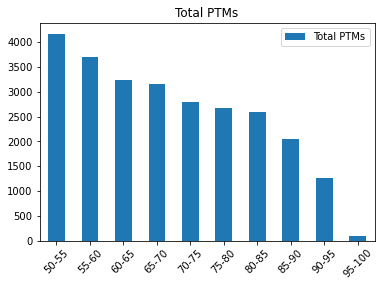

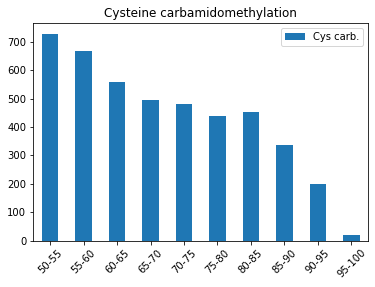

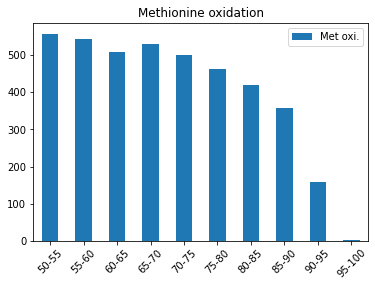

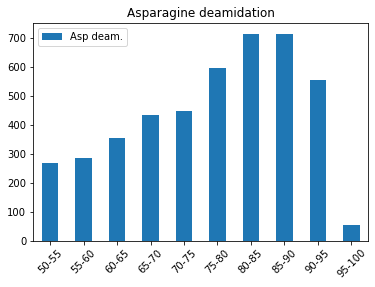

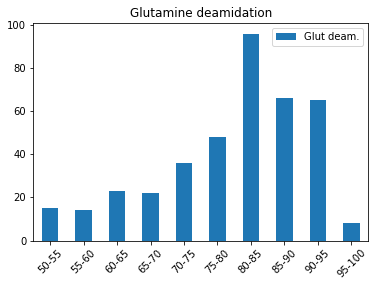

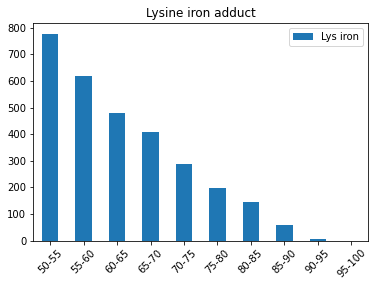

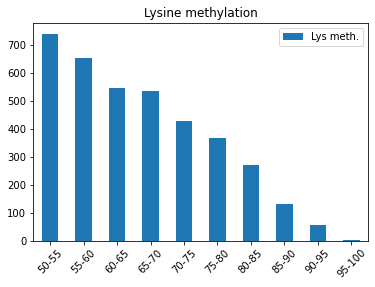

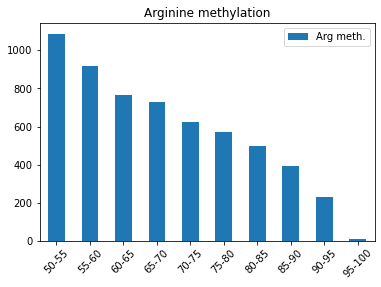

In [14]:
# bar plots of binned PTM data

index = ['50-55', '55-60', '60-65', '65-70', '70-75', '75-80', '80-85', '85-90', '90-95', '95-100']
data = {'Total PTMs': [peaks50.groupby('binned')['ptm-total'].sum()['50-55'], peaks50.groupby('binned')['ptm-total'].sum()['55-60'], peaks50.groupby('binned')['ptm-total'].sum()['60-65'], peaks50.groupby('binned')['ptm-total'].sum()['65-70'], peaks50.groupby('binned')['ptm-total'].sum()['70-75'], peaks50.groupby('binned')['ptm-total'].sum()['75-80'], peaks50.groupby('binned')['ptm-total'].sum()['80-85'], peaks50.groupby('binned')['ptm-total'].sum()['85-90'], peaks50.groupby('binned')['ptm-total'].sum()['90-95'], peaks50.groupby('binned')['ptm-total'].sum()['95-100']],
        'Cys carb.': [peaks50.groupby('binned')['c-carb'].sum()['50-55'], peaks50.groupby('binned')['c-carb'].sum()['55-60'], peaks50.groupby('binned')['c-carb'].sum()['60-65'], peaks50.groupby('binned')['c-carb'].sum()['65-70'], peaks50.groupby('binned')['c-carb'].sum()['70-75'], peaks50.groupby('binned')['c-carb'].sum()['75-80'], peaks50.groupby('binned')['c-carb'].sum()['80-85'], peaks50.groupby('binned')['c-carb'].sum()['85-90'], peaks50.groupby('binned')['c-carb'].sum()['90-95'], peaks50.groupby('binned')['c-carb'].sum()['95-100']],
        'Met oxi.': [peaks50.groupby('binned')['m-oxid'].sum()['50-55'], peaks50.groupby('binned')['m-oxid'].sum()['55-60'], peaks50.groupby('binned')['m-oxid'].sum()['60-65'], peaks50.groupby('binned')['m-oxid'].sum()['65-70'], peaks50.groupby('binned')['m-oxid'].sum()['70-75'], peaks50.groupby('binned')['m-oxid'].sum()['75-80'], peaks50.groupby('binned')['m-oxid'].sum()['80-85'], peaks50.groupby('binned')['m-oxid'].sum()['85-90'], peaks50.groupby('binned')['m-oxid'].sum()['90-95'], peaks50.groupby('binned')['m-oxid'].sum()['95-100']],
        'Asp deam.': [peaks50.groupby('binned')['n-deam'].sum()['50-55'], peaks50.groupby('binned')['n-deam'].sum()['55-60'], peaks50.groupby('binned')['n-deam'].sum()['60-65'], peaks50.groupby('binned')['n-deam'].sum()['65-70'], peaks50.groupby('binned')['n-deam'].sum()['70-75'], peaks50.groupby('binned')['n-deam'].sum()['75-80'], peaks50.groupby('binned')['n-deam'].sum()['80-85'], peaks50.groupby('binned')['n-deam'].sum()['85-90'], peaks50.groupby('binned')['n-deam'].sum()['90-95'], peaks50.groupby('binned')['n-deam'].sum()['95-100']],
        'Glut deam.': [peaks50.groupby('binned')['q-deam'].sum()['50-55'], peaks50.groupby('binned')['q-deam'].sum()['55-60'], peaks50.groupby('binned')['q-deam'].sum()['60-65'], peaks50.groupby('binned')['q-deam'].sum()['65-70'], peaks50.groupby('binned')['q-deam'].sum()['70-75'], peaks50.groupby('binned')['q-deam'].sum()['75-80'], peaks50.groupby('binned')['q-deam'].sum()['80-85'], peaks50.groupby('binned')['q-deam'].sum()['85-90'], peaks50.groupby('binned')['q-deam'].sum()['90-95'], peaks50.groupby('binned')['q-deam'].sum()['95-100']],
        'Lys iron': [peaks50.groupby('binned')['k-iron'].sum()['50-55'], peaks50.groupby('binned')['k-iron'].sum()['55-60'], peaks50.groupby('binned')['k-iron'].sum()['60-65'], peaks50.groupby('binned')['k-iron'].sum()['65-70'], peaks50.groupby('binned')['k-iron'].sum()['70-75'], peaks50.groupby('binned')['k-iron'].sum()['75-80'], peaks50.groupby('binned')['k-iron'].sum()['80-85'], peaks50.groupby('binned')['k-iron'].sum()['85-90'], peaks50.groupby('binned')['k-iron'].sum()['90-95'], peaks50.groupby('binned')['k-iron'].sum()['95-100']],
        'Lys meth.': [peaks50.groupby('binned')['k-meth'].sum()['50-55'], peaks50.groupby('binned')['k-meth'].sum()['55-60'], peaks50.groupby('binned')['k-meth'].sum()['60-65'], peaks50.groupby('binned')['k-meth'].sum()['65-70'], peaks50.groupby('binned')['k-meth'].sum()['70-75'], peaks50.groupby('binned')['k-meth'].sum()['75-80'], peaks50.groupby('binned')['k-meth'].sum()['80-85'], peaks50.groupby('binned')['k-meth'].sum()['85-90'], peaks50.groupby('binned')['k-meth'].sum()['90-95'], peaks50.groupby('binned')['k-meth'].sum()['95-100']],
        'Arg meth.': [peaks50.groupby('binned')['r-meth'].sum()['50-55'], peaks50.groupby('binned')['r-meth'].sum()['55-60'], peaks50.groupby('binned')['r-meth'].sum()['60-65'], peaks50.groupby('binned')['r-meth'].sum()['65-70'], peaks50.groupby('binned')['r-meth'].sum()['70-75'], peaks50.groupby('binned')['r-meth'].sum()['75-80'], peaks50.groupby('binned')['r-meth'].sum()['80-85'], peaks50.groupby('binned')['r-meth'].sum()['85-90'], peaks50.groupby('binned')['r-meth'].sum()['90-95'], peaks50.groupby('binned')['r-meth'].sum()['95-100']]
        }

peaks50bin = pd.DataFrame(data, columns=['Total PTMs','Cys carb.','Met oxi.','Asp deam.', 'Glut deam.', 'Lys iron', 'Lys meth.', 'Arg meth.'], index=index)

ax1 = peaks50bin.plot.bar(y='Total PTMs', rot=45)
ax1.set_title('Total PTMs')

ax2 = peaks50bin.plot.bar(y='Cys carb.', rot=45)
ax2.set_title('Cysteine carbamidomethylation')

ax3 = peaks50bin.plot.bar(y='Met oxi.', rot=45)
ax3.set_title('Methionine oxidation')

ax4 = peaks50bin.plot.bar(y='Asp deam.', rot=45)
ax4.set_title('Asparagine deamidation')

ax5 = peaks50bin.plot.bar(y='Glut deam.', rot=45)
ax5.set_title('Glutamine deamidation')

ax6 = peaks50bin.plot.bar(y='Lys iron', rot=45)
ax6.set_title('Lysine iron adduct')

ax7 = peaks50bin.plot.bar(y='Lys meth.', rot=45)
ax7.set_title('Lysine methylation')

ax7 = peaks50bin.plot.bar(y='Arg meth.', rot=45)
ax7.set_title('Arginine methylation')


## Export stripped peptides at >50% and >80% ALC

In [15]:
# keep only peptide column >50% ALC
pep50 = peaks50[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep50.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_stripped_peptides.txt", header=False, index=False)

# removing redundancy
peaks50dedup = pd.DataFrame.drop_duplicates(pep50)

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

peaks50dedup.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_nonredundant_stripped_peptides.txt", header=False, index=False)


print("# redundant Peaks peptides >50% ALC", len(pep50))
print("# nonredundant Peaks peptides", len(peaks50dedup))

# look
pep50.head()

# redundant Peaks peptides >50% ALC 33188
# nonredundant Peaks peptides 25675


,stripped peptide
0,KELNLDTDLGK
1,KDLESLDSTNK
2,FFLLFK
3,KLFTDYQELMK
4,WALEELLNK


In [16]:
# keep only peptides  >80% ALC
peaks80 = peaks50.loc[peaks50['ALC (%)'] >= 80]

# keep only peptide column 
pep80 = peaks80[["stripped peptide"]]

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

pep80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_stripped_peptides.txt", header=False, index=False)

# removing redundancy
peaks80dedup = pd.DataFrame.drop_duplicates(pep80)

# write altered dataframe to new txt file
# used header and index parameters to get rid of 'Peptide' header and the indexing

peaks80dedup.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_nonredundant_stripped_peptides.txt", header=False, index=False)


print("# redundant Peaks peptides >80% ALC", len(pep80))
print("# nonredundant Peaks peptides >80% ALC", len(peaks80dedup))

# look
pep80.head()

# redundant Peaks peptides >80% ALC 13522
# nonredundant Peaks peptides >80% ALC 8945


,stripped peptide
0,KELNLDTDLGK
1,KDLESLDSTNK
2,FFLLFK
3,KLFTDYQELMK
4,WALEELLNK


## Unipept lowest common ancestor peptide analysis:

### This tool returns the taxonomic lowest common ancestor for a given tryptic peptide. Here we're running all our de novo peptides through to determine their specificity and ability to ID organismal and functional source.

### You can run the `pept2lca` command as part of a [web server](https://unipept.ugent.be/datasets) or using the command line interface ([info here](https://unipept.ugent.be/clidocs)).

### I exported the LCA results to a .csv and placed into my /analysis/unipept directory:

In [17]:
cd /home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/unipept/

/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/unipept


In [18]:
ls

 interpro/
 med2_1_1fdr_db_nomods.jpg
 med2_1_1fdr_db_nomods.svg
 med2_1_Comet.2.5.png
 med2_1_dn_50alc_nomods.png
 med2_1_dn_80alc_nomods.png
 med2_1_dno_50alc_nomods.png
 med2_1_PeaksDN50.png
 med2_1_PeaksDN80.png
 med2_1_PepProp.90.png
 med2_2_Comet.2.5.png
 med2_2_DN50.png
 med2_2_DN80.png
 med2_2_PepProp.90.png
 MED2_combine_CometXCorr2.5_lca.csv
 MED2_combine_CometXCorr2.5_lca.ods
 MED2_combine_CometXCorr3_lca.csv
 MED2_combine_CometXCorr3_lca.ods
'med2_combined_Comet>2.5_treeview_to_Pro.png'
 med2_combined_DN50_treeview_to_Pro.png
 med2_combined_dn80.png
 med2_combined_DN80_treeview_to_Pro.png
 MED2_combine_DN50_lca.csv
 MED2_combine_DN50_lca.ods
 MED2_combine_DN50_length_spec.csv
 MED2_combine_DN50_length_spec.ods
 MED2_combine_DN80_lca.csv
 MED2_combine_DN80_lca.ods
 med2_combined_PepProp90.png
 MED4_GRaa_tryptic_peptides_LCA.png
 similarity_matrix_ProSyn_MED4GRaa.png
 unique_peptides_5_p.marinus.06.05.2020.png
'unique_peptides_5_p.marinus&MED4GRaa.06.05.2020.png'


In [36]:
lca50 = pd.read_csv('MED2_combine_DN50_length_spec.csv')
lca80 = pd.read_csv('MED2_combine_DN80_length_spec.csv')
lcaC3 = pd.read_csv('MED2_combine_CometXCorr3_length_spec.csv')

/home/millieginty/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (0,2,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Visualizing the LCA results:

In [37]:
lcalen50 = lca50[['xkingdom-len', 'kingdom-len', 'phylum-len', 'species-len']].copy()    
lcalen80 = lca80[['xkingdom-len', 'kingdom-len', 'phylum-len', 'species-len']].copy()  
lcalenC3 = lcaC3[['xkingdom-len', 'kingdom-len', 'phylum-len', 'species-len']].copy()  

Text(0.5, 1.1, 'MED4 de novo peptides > 50% ALC taxonomic specificity')

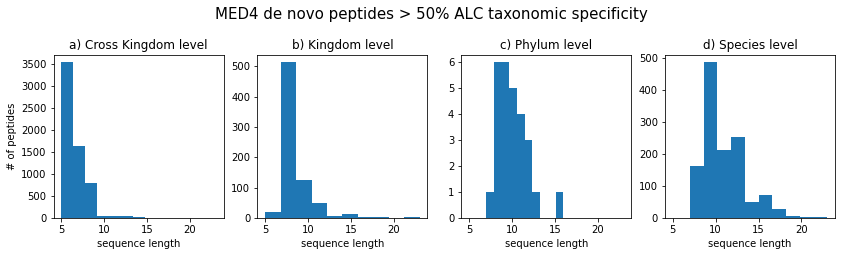

In [32]:
# plot Peaks > 50% ALC peptide taxonomic specificity per peptide length as histograms

fig, axs = plt.subplots(1, 4, figsize=(14, 3), sharex=True)


axs[0].hist(lcalen50['xkingdom-len'])
axs[0].set_title('a) Cross Kingdom level')
axs[0].set_ylabel('# of peptides')
axs[0].set_xlabel('sequence length')

axs[1].hist(lcalen50['kingdom-len'])
axs[1].set_title('b) Kingdom level')
axs[1].set_xlabel('sequence length')

axs[2].hist(lcalen50['phylum-len'])
axs[2].set_title('c) Phylum level')
axs[2].set_xlabel('sequence length')

axs[3].hist(lcalen50['species-len'])
axs[3].set_title('d) Species level')
axs[3].set_xlabel('sequence length')

fig.suptitle('MED4 de novo peptides > 50% ALC taxonomic specificity', y = 1.1, size = 15)

Text(0.5, 1.1, 'MED4 de novo peptides > 80% ALC taxonomic specificity')

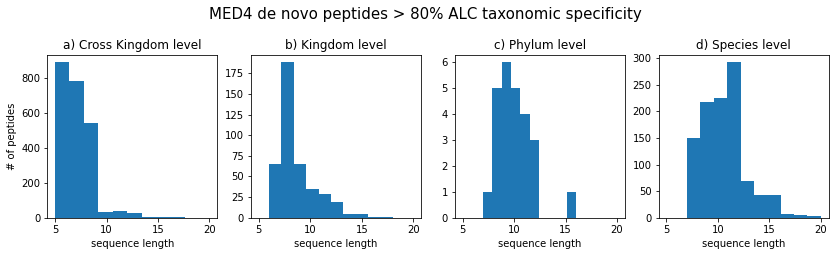

In [33]:
# plot Peaks > 80% ALC peptide taxonomic specificity per peptide length as histograms

fig, axs = plt.subplots(1, 4, figsize=(14, 3), sharex=True)


axs[0].hist(lcalen80['xkingdom-len'])
axs[0].set_title('a) Cross Kingdom level')
axs[0].set_ylabel('# of peptides')
axs[0].set_xlabel('sequence length')

axs[1].hist(lcalen80['kingdom-len'])
axs[1].set_title('b) Kingdom level')
axs[1].set_xlabel('sequence length')

axs[2].hist(lcalen80['phylum-len'])
axs[2].set_title('c) Phylum level')
axs[2].set_xlabel('sequence length')

axs[3].hist(lcalen80['species-len'])
axs[3].set_title('d) Species level')
axs[3].set_xlabel('sequence length')

fig.suptitle('MED4 de novo peptides > 80% ALC taxonomic specificity', y = 1.1, size = 15)

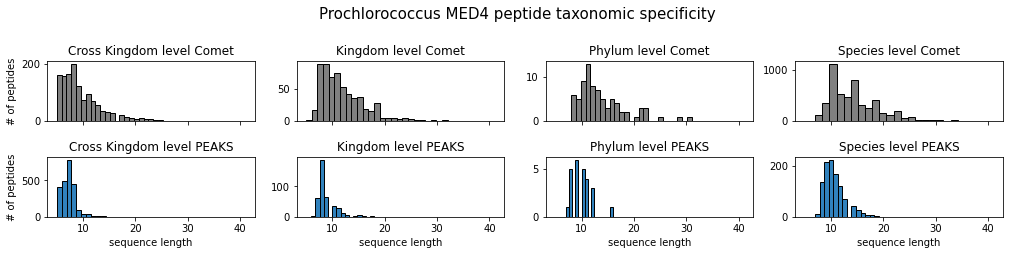

In [72]:
# plot Comet >XCorr 3 peptide taxonomic specificity per peptide length as histograms
# and plot DN80 Peaks peptides

fig, axs = plt.subplots(2, 4, figsize=(14, 3), sharex=True)

fig.tight_layout(h_pad=3)

axs[0,0].hist(lcalenC3['xkingdom-len'], bins = 25, color='grey', edgecolor = 'black')
axs[0,0].set_title('Cross Kingdom level Comet')
axs[0,0].set_ylabel('# of peptides')
#axs[0,0].set_xlabel('sequence length')

axs[0,1].hist(lcalenC3['kingdom-len'], bins = 25, color='grey', edgecolor = 'black')
axs[0,1].set_title('Kingdom level Comet')
#axs[0,1].set_xlabel('sequence length')

axs[0,2].hist(lcalenC3['phylum-len'], bins = 25, color='grey', edgecolor = 'black')
axs[0,2].set_title('Phylum level Comet')
#axs[0,2].set_xlabel('sequence length')

axs[0,3].hist(lcalenC3['species-len'], bins = 25, color='grey', edgecolor = 'black')
axs[0,3].set_title('Species level Comet')
#axs[0,3].set_xlabel('sequence length')

axs[1,0].hist(lcalen80['xkingdom-len'], bins = 15, color='#3182bd', edgecolor = 'black')
axs[1,0].set_title('Cross Kingdom level PEAKS')
axs[1,0].set_ylabel('# of peptides')
axs[1,0].set_xlabel('sequence length')

axs[1,1].hist(lcalen80['kingdom-len'], bins = 15, color='#3182bd', edgecolor = 'black')
axs[1,1].set_title('Kingdom level PEAKS')
axs[1,1].set_xlabel('sequence length')

axs[1,2].hist(lcalen80['phylum-len'], bins = 15, color='#3182bd', edgecolor = 'black')
axs[1,2].set_title('Phylum level PEAKS')
axs[1,2].set_xlabel('sequence length')

axs[1,3].hist(lcalen80['species-len'], bins = 15, color='#3182bd', edgecolor = 'black')
axs[1,3].set_title('Species level PEAKS')
axs[1,3].set_xlabel('sequence length')

fig.suptitle('Prochlorococcus MED4 peptide taxonomic specificity', y = 1.1, size = 15)
plt.subplots_adjust(top=0.85)

plt.savefig("MED4-Comet_Peaks-taxa-hist.png")

## Sequence to protein mapping with PepExplorer

### PepExplorer (Leprevost et al., 2014) is a sequence similarity-driven tool that takes the output of our de novo algorithm (PEAK), which contain candidate sequences with PTMs and confidence scores, and maps them to a user-defined target-decoy sequence database.

### PepExplorer is part of the Pattern Lab for Proteomics suite of tools available for free download [here](http://proteomics.fiocruz.br/software/pepexplorer/).

### I used PepExplorer 0.1.0.78 on my PC (x64 Windows 10). The parameters for searching de novo results (>50% ALC) were:

    - Min AAs in peptide: 5
    - Decoy method: reverse
    - PEAKS 8.0 parameters
    
### I exported the results of the alignments of each MED4 replicate vs. the MED4 sequence database (proteome from GenBank) and moved the .txt results to my local machine in this git directory. Using LibreOffice Calc I also took out only the protein IDs/# of alignments/spec counts/description and saved as a .csv:

In [ ]:
cd /home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/

In [ ]:
ls

In [ ]:
# combining and exporting results for PepExplorer results from de novo peptide > 50% ALC
# read the protein files into dataframes and combined the replicates

pe1 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL95_MED2_trypsin_1_PTMopt_DN50_PepExplorer_vs_MED4Graa_proteins.csv")
pe2 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL95_MED2_trypsin_2_PTMopt_DN50_PepExplorer_vs_MED4Graa_proteins.csv")

frames = [pe1, pe2]

# concatenate dataframes
pe50 = pd.concat(frames, sort=False)

# let's also make a dataframe that's just the proteins
pe50prot = pe50[['ProteinID']].copy() 

# removing redundancy
pe50protdd = pd.DataFrame.drop_duplicates(pe50prot)

# how many redundant proteins?
print("# redundant PeaksDN50 proteins = ", len(pe50prot))

# how many nonredundant proteins?
print("# nonredundant PeaksDN50 proteins = ", len(pe50protdd))

# export as a .txt file without headers
pe50protdd.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL4_MED2_combine_DN50PepEx_proteins.txt", header=False, index=False)

# export as a .txt file without headers
pe50.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL4_MED2_combine_DN50PepEx.csv")

# take a look
pe50.head()

In [ ]:
# combining and exporting results for PepExplorer results from de novo peptide > 80% ALC
# read the protein files into dataframes and combined the replicates

pe1 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL95_MED2_trypsin_1_PTMopt_DN80_PepExplorer_vs_MED4Graa_proteins.csv")
pe2 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL95_MED2_trypsin_2_PTMopt_DN80_PepExplorer_vs_MED4Graa_proteins.csv")

frames = [pe1, pe2]

# concatenate dataframes
pe80 = pd.concat(frames, sort=False)

# let's also make a dataframe that's just the proteins
pe80prot = pe80[['ProteinID']].copy() 

# removing redundancy
pe80protdd = pd.DataFrame.drop_duplicates(pe80prot)

# how many redundant proteins?
print("# redundant PeaksDN80 proteins = ", len(pe80prot))

# how many nonredundant proteins?
print("# nonredundant PeaksDN80 proteins = ", len(pe80protdd))

# export as a .txt file without headers
pe80protdd.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL4_MED2_combine_DN80PepEx_proteins.txt", header=False, index=False)

# export as a .txt file without headers
pe80.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/analyses/pronovo-2020/pepexplorer/med4-PTMopt/RAL4_MED2_combine_DN80PepEx.csv")

# take a look
pe80.head()

### Let's compare to our Comet results!

In [ ]:
cd /home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/

In [ ]:
ls

In [ ]:
# export for XCorr >3
# read the CSVs of each replicate into a datadrame we name 'comet' using the pandas read_csv function
comet1 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_1_PTMopt_Comet.csv")
comet2 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_2_PTMopt_Comet.csv")

frames = [comet1, comet2]

# concatenate dataframes
cometall = pd.concat(frames, sort=False)

# get rid of these few weirdos
cometall = cometall[cometall.xcorr != '[unavailable]']

# let's only keep PSMs > XCorr 3 (see MED4 Comet notebook - this keeps an FDR < 1%)
# need to convert Xcorr column from strings to numeric so we can use loc
cometall['xcorr'] = pd.to_numeric(cometall['xcorr'])
comet3 = cometall.loc[cometall['xcorr'] >= 3]

# getting rid of any DECOY protein IDs
cometpmm3 = comet3[~comet3['protein'].str.contains("DECOY")]

# let's also make a dataframe that's just the proteins
cometprot = cometpmm3[['protein']].copy() 

# let's also deduplicate
cometprotdd = pd.DataFrame.drop_duplicates(cometprot)

print("# redundant Comet peptides", len(cometprot))
print("# nonredundant Comet peptides", len(cometprotdd))

# export as a .txt file without headers
cometprotdd.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_combine_Comet3Xcorr_proteins.txt", header=False, index=False)

#look at the dataframe
cometprotdd.head()

In [ ]:
# export for XCorr >2.5
# read the CSVs of each replicate into a datadrame we name 'comet' using the pandas read_csv function
comet1 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_1_PTMopt_Comet.csv")
comet2 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_trypsin_2_PTMopt_Comet.csv")

frames = [comet1, comet2]

# concatenate dataframes
cometall = pd.concat(frames, sort=False)

# get rid of these few weirdos
cometall = cometall[cometall.xcorr != '[unavailable]']

# let's only keep PSMs > XCorr 2.5 (see MED4 Comet notebook - this keeps an FDR < 1%)
# need to convert Xcorr column from strings to numeric so we can use loc
cometall['xcorr'] = pd.to_numeric(cometall['xcorr'])
comet25 = cometall.loc[cometall['xcorr'] >= 2.5]

# getting rid of any DECOY protein IDs
cometpmm25 = comet25[~comet25['protein'].str.contains("DECOY")]

# let's also make a dataframe that's just the proteins
cometprot = cometpmm25[['protein']].copy() 

# let's also deduplicate
cometprotdd25 = pd.DataFrame.drop_duplicates(cometprot)

print("# redundant Comet peptides", len(cometprot))
print("# nonredundant Comet peptides", len(cometprotdd))

# export as a .txt file without headers
cometprotdd25.to_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL4_MED2_combine_Comet2.5Xcorr_proteins.txt", header=False, index=False)

#look at the dataframe
cometprotdd25.head()